<a href="https://colab.research.google.com/github/ShinnosukeAsaga/Mathematical-Modeling/blob/main/Task_2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
#Parameter setup
road_length = 100 #Length of the road
num_lanes = 2
p_slow = 0.3 #Random Slowdown Chance
spead_max  = 5    #Maximum　Speed
num_steps = 100
signal_positions = [30, 70]
signal_cycle = 20  # red:10, blue:10

In [3]:
# Set Up
road = -np.ones((num_lanes, road_length), dtype=int)
car_positions = []
for lane in range(num_lanes):
    count = 0
    while count < int(road_length * p_slow):
        pos = np.random.randint(0, road_length)
        if road[lane, pos] == -1:
            road[lane, pos] = np.random.randint(0, spead_max + 1)
            car_positions.append((lane, pos))
            count += 1

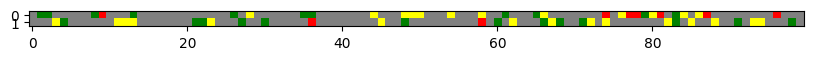

In [4]:
# Preparing for drawing
from matplotlib.colors import ListedColormap, BoundaryNorm

# 赤（停止=0）、黄（1,2）、緑（3以上）、灰色（-1：空き）
cmap = ListedColormap(['gray', 'red', 'yellow', 'yellow', 'green', 'green', 'green'])
norm = BoundaryNorm([-1.5, -0.5, 0.5, 2.5, 3.5, 4.5, 5.5], cmap.N)

fig, ax = plt.subplots(figsize=(10, 2))
im = ax.imshow(road, cmap=cmap, norm=norm)


In [5]:
def update(frame):
    global road
    new_road = -np.ones_like(road)
    red_signals = [(pos, frame % signal_cycle < signal_cycle // 2) for pos in signal_positions]

    for lane in range(num_lanes):
        for x in range(road_length):
            v = road[lane, x]
            if v >= 0:
                d = 1
                while d <= spead_max and (x + d) % road_length not in np.where(road[lane] >= 0)[0]:
                    d += 1
                #Rule1 acceleration
                new_v = min(v + 1, d - 1, spead_max)
                if np.random.rand() < 0.3:
                    new_v = max(0, new_v - 1)
                #Rule2 Slow down
                #Rule3 Random Deceleration
                #Rule4 Movement
                new_x = (x + new_v) % road_length
                stop = False
                for pos, is_red in red_signals:
                    if is_red and x < pos <= new_x:
                        stop = True
                        new_x = pos - 1
                        new_v = max(0, pos - x - 1)
                if new_road[lane, new_x] == -1:
                    new_road[lane, new_x] = new_v
                else:
                    new_road[lane, x] = v

    im.set_array(new_road)
    road = new_road
    return [im]

ani = animation.FuncAnimation(fig, update, frames=num_steps, interval=200, blit=True)


### Nagel-Schreckenberg Model: Update Rules

The update for each vehicle *i* proceeds in four steps at each time *t*:

---

#### 1. Acceleration

$$
v_{i}(t+1) = \min \left\{ v_{i}(t) + 1,\ v_{\text{max}} \right\}
$$

- $ v_{i}(t)$　 Speed of vehicle *i* at time
- $ v_{\text{max}} $: Maximum allowed speed

---

#### 2. Slowing Down (Due to Other Vehicles)

$$
v_{i}(t+1) = \min \left\{ v_{i}(t+1),\ d_{i}(t) \right\}
$$

- $ d_{i}(t) $: Number of empty cells in front of vehicle *i*  
  (i.e., distance to the next vehicle in front minus 1)

This prevents collisions by ensuring the vehicle does not move farther than the gap.

---

#### 3. Randomization (Stochastic Braking)

With probability $ p $, the speed is reduced by 1:

$$
v_{i}(t+1) =
\begin{cases}
\max \left\{ v_{i}(t+1) - 1,\ 0 \right\}, & \text{with probability } p \\
v_{i}(t+1), & \text{with probability } 1 - p
\end{cases}
$$

- $ p $: Random slowdown probability (e.g., 0.25)

This introduces variability in driver behavior.

---

#### 4. Vehicle Movement

After updating speed, the vehicle moves:

$$
x_{i}(t+1) = x_{i}(t) + v_{i}(t+1)
$$

- $ x_{i}(t) $: Position of vehicle *i* at time \( t \)

The vehicle advances by its updated speed.

---


In [6]:
#Save
ani.save("nagel_schreckenberg_animation.mp4", writer='ffmpeg', dpi=200)
plt.close()